# библиотеки

In [1]:
%pylab inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
import pylab

def invboxcox(y,lmbda):
  if lmbda == 0:
    return(np.exp(y))
  else:
    return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


# Загрузка

In [22]:
# Этот набор данных содержит ежемесячное количество пассажиров в системе общественного транспорта Портленда с января 1960 по июнь 1969 года
data = pd.read_csv('Portland.csv', index_col=['Month'], parse_dates=['Month'], dayfirst=True)

In [17]:
data

Passenger
Month                
1960-01-01        648
1960-02-01        646
1960-03-01        639
1960-04-01        654
1960-05-01        630
...               ...
1969-02-01       1425
1969-03-01       1419
1969-04-01       1432
1969-05-01       1394
1969-06-01       1327

[114 rows x 1 columns]

Text(0, 0.5, 'Passenger')

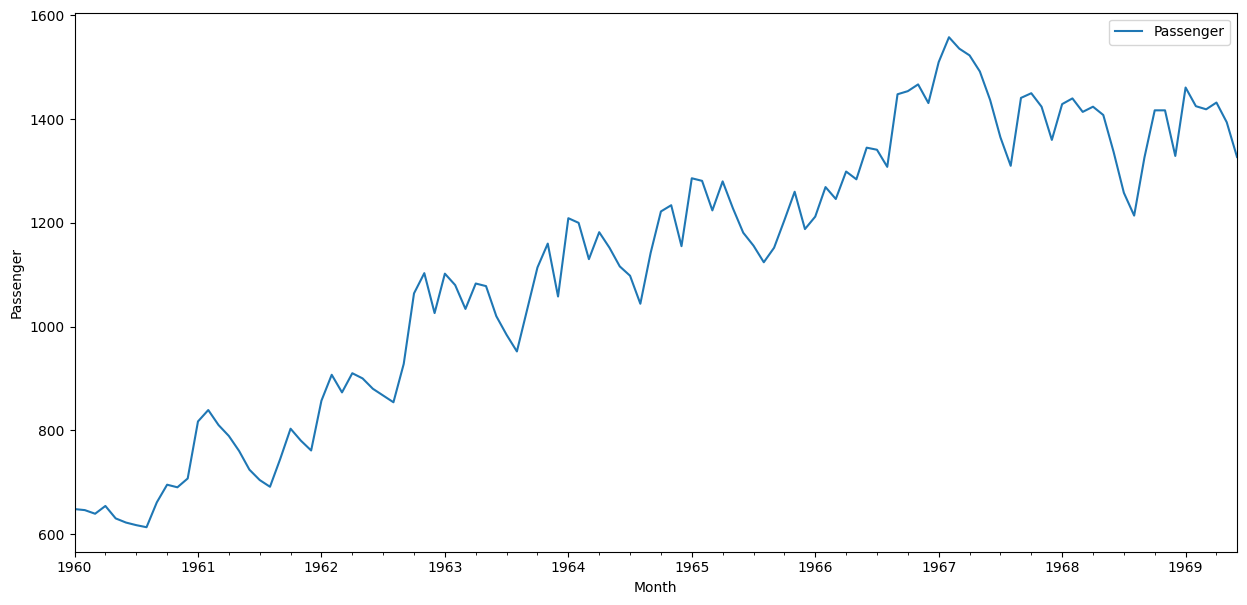

In [18]:
data.plot(figsize = (15,7))
plt.ylabel('Passenger')

In [19]:
sm.tsa.stattools.adfuller(data.Passenger)

(-1.5365971444531596,
 0.5153358797821735,
 12,
 101,
 {'1%': -3.4968181663902103,
  '5%': -2.8906107514600103,
  '10%': -2.5822770483285953},
 1028.4238367341432)

Поскольку p-значение не меньше 0,05, мы не можем отвергнуть нулевую гипотезу, значит ряд не стационарен

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.515336


<Figure size 1500x1000 with 0 Axes>

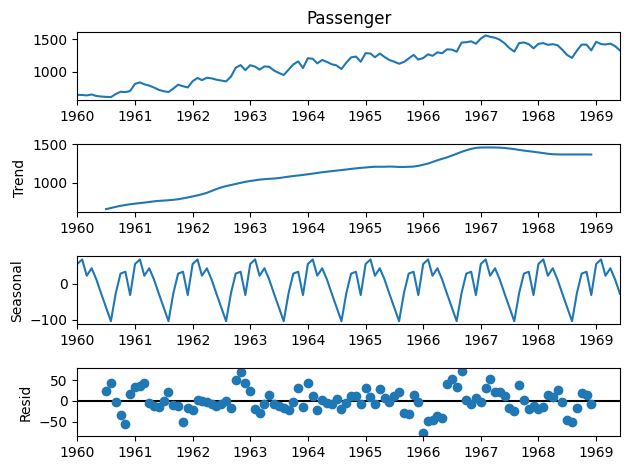

In [21]:
plt.figure(figsize = (15,10))
sm.tsa.seasonal_decompose(data.Passenger).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Passenger)[1])

# Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 1.637493
Критерий Дики-Фуллера: p=0.540607


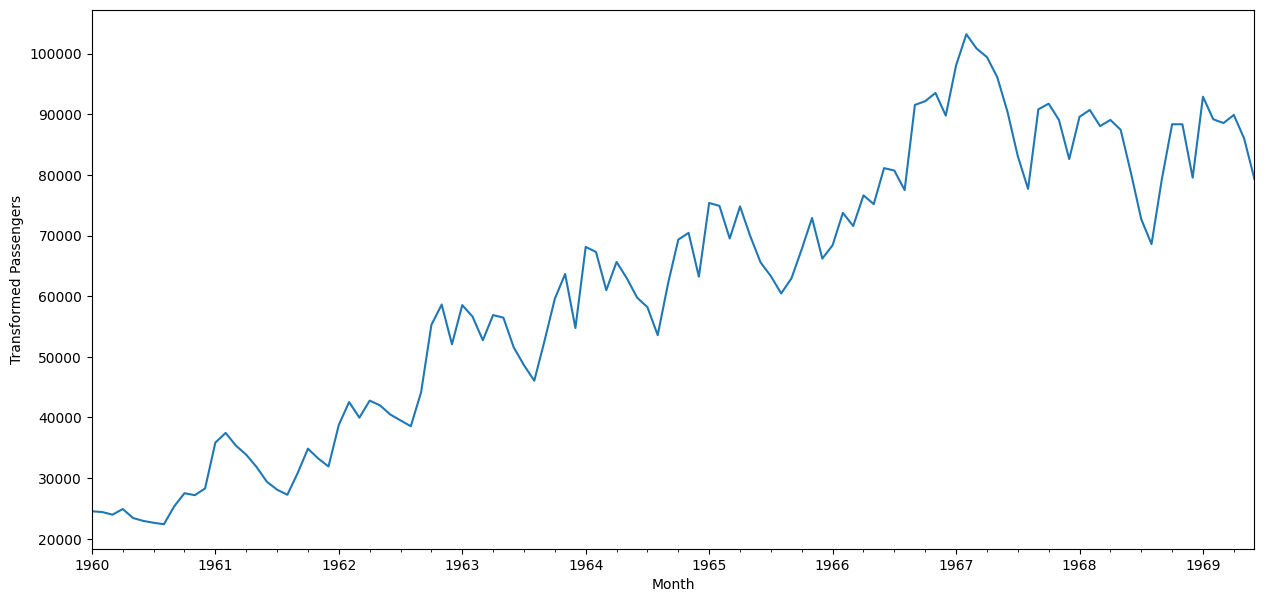

In [24]:
data['Passenger_box'], lmbda = stats.boxcox(data.Passenger)
data.Passenger_box.plot(figsize=(15,7))
plt.ylabel(u'Transformed Passengers')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Passenger_box)[1])

# Стационарность

Визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.091159


<Figure size 1500x1000 with 0 Axes>

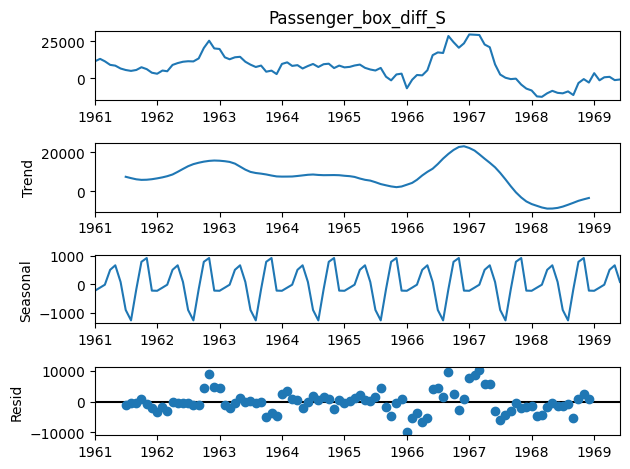

In [25]:
plt.figure(figsize = (15,10))
data['Passenger_box_diff_S'] = data.Passenger_box - data.Passenger_box.shift(12)
sm.tsa.seasonal_decompose(data.Passenger_box_diff_S[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Passenger_box_diff_S[12:])[1])

Критерий Дики-Фуллера: p=0.000300


<Figure size 1500x1000 with 0 Axes>

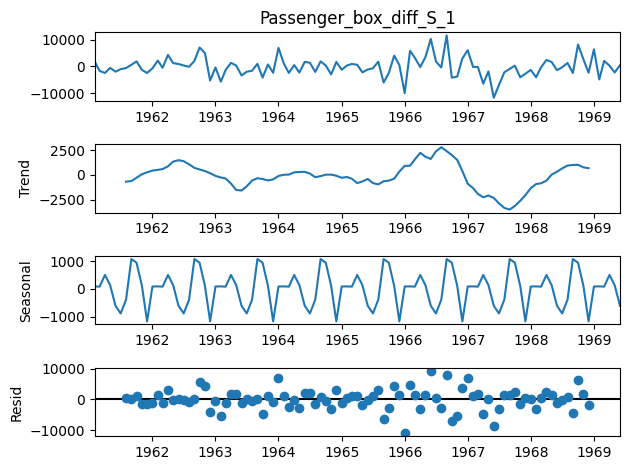

In [26]:
plt.figure(figsize = (15,10))
data['Passenger_box_diff_S_1'] = data.Passenger_box_diff_S - data.Passenger_box_diff_S.shift(1)
sm.tsa.seasonal_decompose(data.Passenger_box_diff_S_1[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Passenger_box_diff_S_1[13:])[1])

Будем считать, что  d=1,D=1 , т.е. мы определились с порядком дифференцирования.

# Подбор модели

Посмотрим на ACF и PACF полученного ряда:

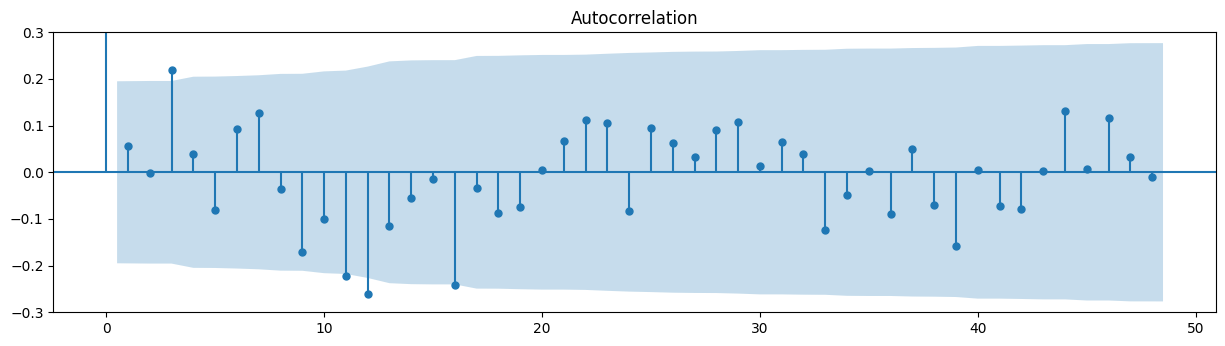

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


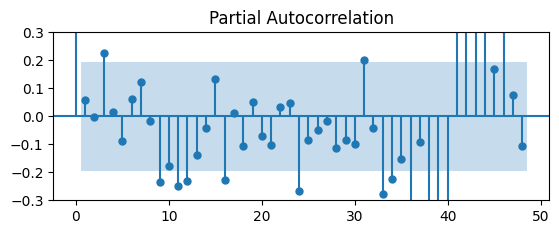

In [27]:
plt.figure(figsize = (15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.Passenger_box_diff_S_1[13:].values.squeeze(), lags=48, ax=ax)
plt.ylim([-0.3, 0.3])
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.Passenger_box_diff_S_1[13:].values.squeeze(), lags=48, ax=ax)
plt.ylim([-0.3, 0.3])
pylab.show()

Начальное значение для параметра Q даёт номер последнего сезонного лага, при котором автокорреляция значима. В рассматриваемом примере сезонных лагов со значимой корреляцией Q = 1. Параметр q задаётся номером последнего несезонного лага, при котором автокорреляция значима. В данном случае можно взять начальное значение q = 1.

Начальное приближение P = 1, поскольку длина сезонного периода S = 12. Аналогично, p задаётся как номер последнего несезонного лага, при котором частичная автокорреляция значима. В данном случае можно взять начальное приближение
p = 1.

Начальные приближения:  Q=1,q=1,P=1,p=1

In [28]:
ps = range(0, 1)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [29]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [30]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
      model=sm.tsa.statespace.SARIMAX(data.Passenger_box[:135], order=(param[0], d, param[1]), 
                                      seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)

    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
      print('wrong parameters:', param)
      continue
    aic = model.aic

    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
      best_model = model
      best_aic = aic
      best_param = param
    results.append([param, model.aic])

    
warnings.filterwarnings('default')

CPU times: user 1.72 s, sys: 1.66 s, total: 3.38 s
Wall time: 3.21 s


In [31]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True)[:5])

     parameters          aic
3  (0, 0, 1, 1)  1930.600991
1  (0, 0, 0, 1)  1934.632730
7  (0, 1, 1, 1)  1934.999930
5  (0, 1, 0, 1)  1936.192953
2  (0, 0, 1, 0)  1939.639653


In [32]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                        Passenger_box   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -962.300
Date:                              Thu, 06 Apr 2023   AIC                           1930.601
Time:                                      03:16:03   BIC                           1938.446
Sample:                                  01-01-1960   HQIC                          1933.777
                                       - 06-01-1969                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.3417      0.169      2.016      0.044       0.010       0.674
ma.S.L12      -0.81

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Критерий Стьюдента: p=0.498073
Критерий Дики-Фуллера: p=0.000000


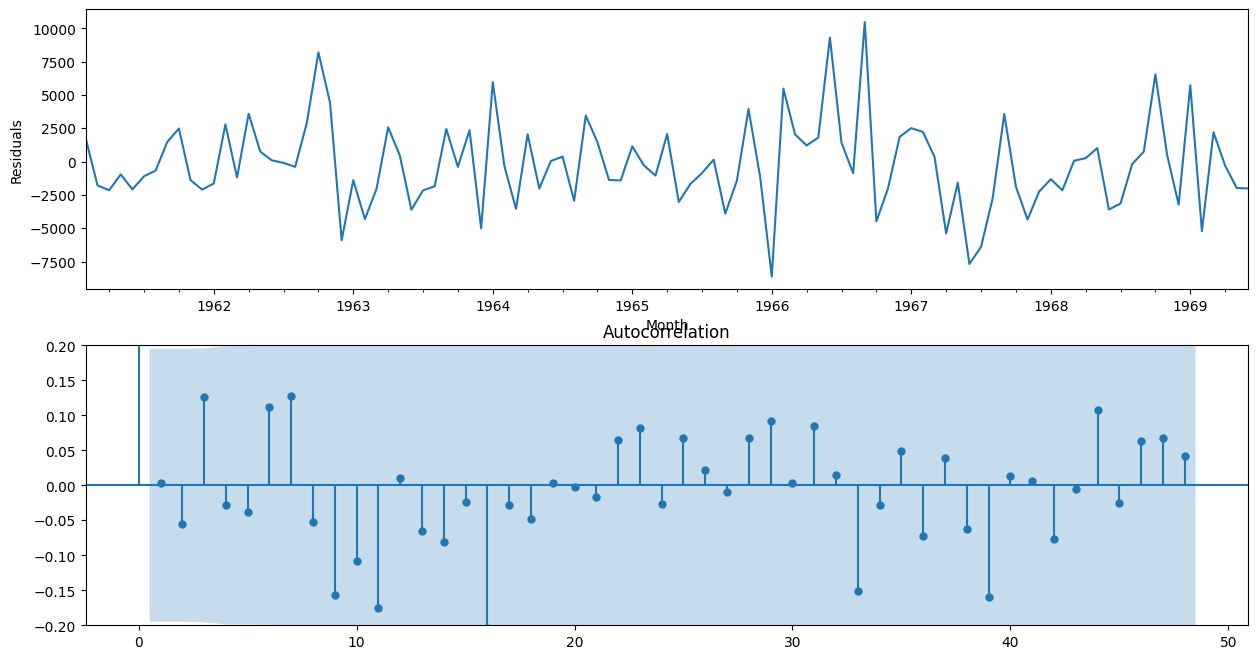

In [33]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
plt.ylim([-0.2, 0.2])

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

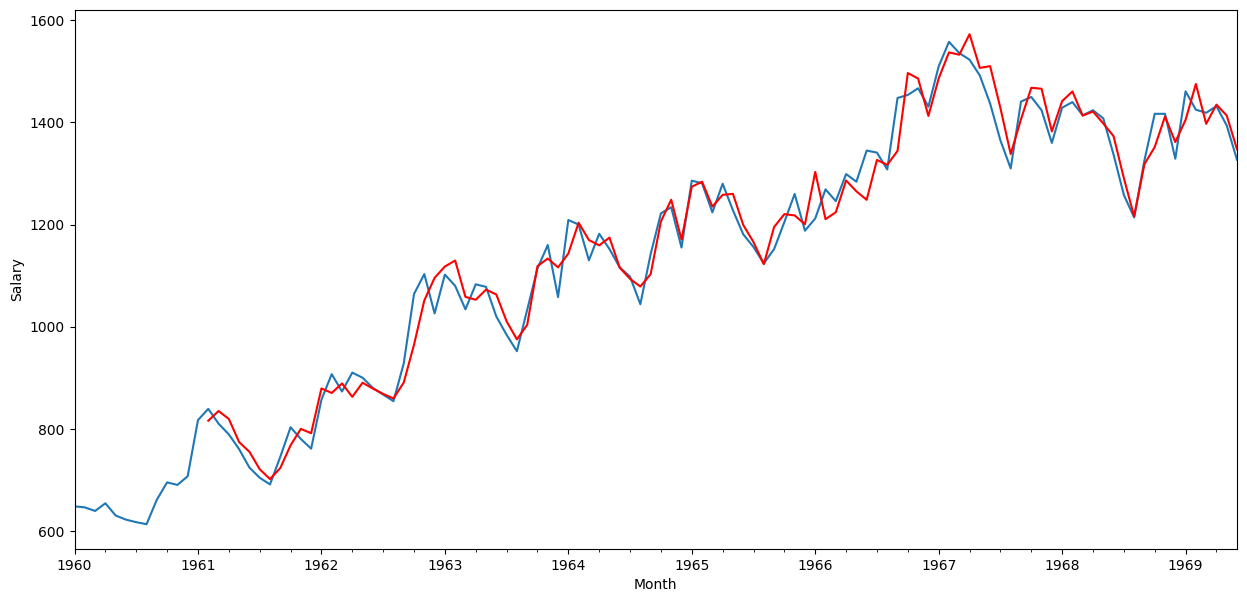

In [35]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
data.Passenger.plot()
data.model[13:].plot(color='r')
plt.ylabel('Salary')
plt.show()